In [1]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import torch

from sklearn.preprocessing import MinMaxScaler

In [2]:
def load_dataset():
    df = pd.read_csv('c:/workspace/dillon.csv')

    # Remove data with NaN values
    df = df.dropna()
    
    # Separate the datasets
    X = df.drop(['date', 'hour'], axis=1)
    
    # Scale the X dataset
    ss = MinMaxScaler() 
    X = ss.fit_transform(X)
    with open('c:/workspace/ae_min_max_scaler.skl', 'wb') as f:
        pickle.dump(ss, f)
   
    return X, ss

In [3]:
dataset, columns = load_dataset()
dataset = torch.from_numpy(dataset).float().cuda()
batch_size = 32

loader = torch.utils.data.DataLoader(dataset = dataset,
                                     batch_size = batch_size,
                                     shuffle = True)

In [4]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, num_features: int):
        super().__init__()
        self.num_features = num_features
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(self.num_features, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 9)
        ).cuda()

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(9, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, self.num_features),
            torch.nn.Sigmoid()
        ).cuda()

    def scenario_1d(self, l1: int):
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(self.num_features, l1)
        ).cuda()

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(l1, self.num_features),
            torch.nn.Sigmoid()
        ).cuda()
    
    def scenario_2d(self, l2: int, l1: int):
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(self.num_features, l2),
            torch.nn.ReLU(),
            torch.nn.Linear(l2, l1)
        ).cuda()

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(l1, l2),
            torch.nn.ReLU(),
            torch.nn.Linear(l2, self.num_features),
            torch.nn.Sigmoid()
        ).cuda()

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded

In [14]:
max_neurons = 200
model = AutoEncoder(dataset.size()[1])
loss_function = torch.nn.MSELoss()
epochs = 10
grid_count = 40

In [15]:
def grid_search_2d():
    output = []

    coly = np.linspace(5, max_neurons, grid_count, dtype=int)

    X, Y = np.meshgrid(coly, coly)

    for l1, l2 in [(x, y) for y in coly for x in coly]:
        print(f"Layers: ({l1}, {l2})", end="")
        
        if l1 > 50:
            output.append(0)
            print(", too loose")
            continue

        if l1 > l2:
            output.append(0)
            print(", illogical")
            continue

        if (l1 + l2) > max_neurons:
            output.append(0)
            print(", too big")
            continue

        model.scenario_2d(l2, l1)
        optimizer = torch.optim.Adam(model.parameters())

        for _ in range(epochs):
            cost = 0

            for batch in loader:
                reconstructed = model(batch)

                loss = loss_function(reconstructed, batch)
                cost += loss

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            print(f", {cost / len(loader):.5f}", end="")

        print()
        output.append(float(f"{cost / len(loader):.5f}"))
    
    return X, Y, output

X, Y, output = grid_search_2d()

Layers: (5, 5), 0.02883, 0.01754, 0.01654, 0.01640, 0.01633, 0.01630, 0.01629, 0.01629, 0.01628, 0.01627
Layers: (10, 5), illogical
Layers: (15, 5), illogical
Layers: (20, 5), illogical
Layers: (25, 5), illogical
Layers: (30, 5), illogical
Layers: (35, 5), illogical
Layers: (40, 5), illogical
Layers: (45, 5), illogical
Layers: (50, 5), illogical
Layers: (55, 5), too loose
Layers: (60, 5), too loose
Layers: (65, 5), too loose
Layers: (70, 5), too loose
Layers: (75, 5), too loose
Layers: (80, 5), too loose
Layers: (85, 5), too loose
Layers: (90, 5), too loose
Layers: (95, 5), too loose
Layers: (100, 5), too loose
Layers: (105, 5), too loose
Layers: (110, 5), too loose
Layers: (115, 5), too loose
Layers: (120, 5), too loose
Layers: (125, 5), too loose
Layers: (130, 5), too loose
Layers: (135, 5), too loose
Layers: (140, 5), too loose
Layers: (145, 5), too loose
Layers: (150, 5), too loose
Layers: (155, 5), too loose
Layers: (160, 5), too loose
Layers: (165, 5), too loose
Layers: (170, 5),

C:\Users\oliev\AppData\Local\Temp\ipykernel_7732\3023120596.py:2: RuntimeWarning: divide by zero encountered in log
  Z = np.log(Z)


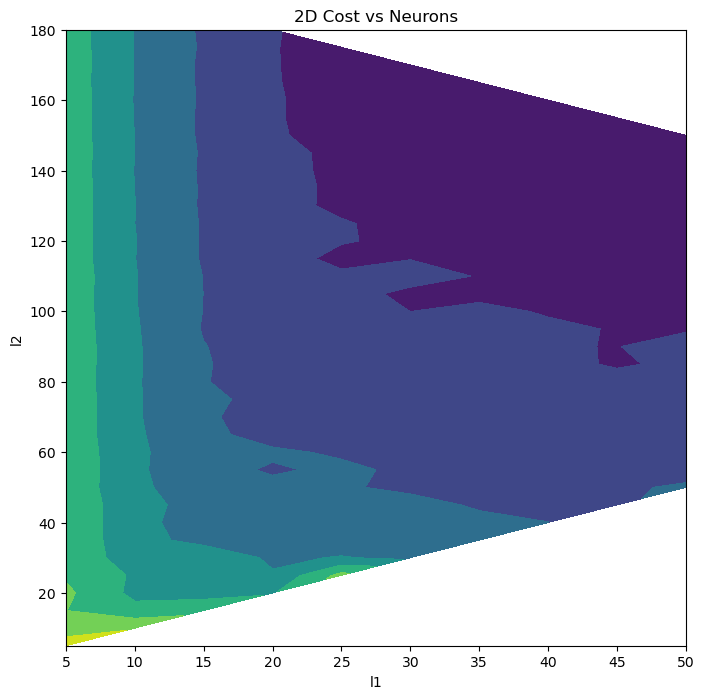

In [17]:
Z = np.reshape(output, (grid_count, grid_count))
Z = np.log(Z)
fig, ax = plt.subplots(figsize=(8, 8))

ax.title.set_text('2D Cost vs Neurons')
ax.contourf(X, Y, Z)
ax.set_xlabel('l1')
ax.set_ylabel('l2')
ax.set_xlim(5, 50)
ax.set_ylim(5, 180)
plt.show()

In [2]:
def grid_search_1d():
    output = []

    coly = np.linspace(5, max_neurons, grid_count, dtype=int)

    for l1 in coly:
        print(f"Layers: ({l1})", end="")
        
        if l1 > 50:
            output.append(0)
            print(", too loose")
            continue

        model.scenario_1d(l1)
        optimizer = torch.optim.Adam(model.parameters())

        for _ in range(epochs):
            cost = 0

            for batch in loader:
                reconstructed = model(batch)

                loss = loss_function(reconstructed, batch)
                cost += loss

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            print(f", {cost / len(loader):.5f}", end="")

        print()
        output.append(float(f"{cost / len(loader):.5f}"))
    
    return coly, output

X, output = grid_search_1d()

NameError: name 'np' is not defined

In [ ]:
    output_df = pd.DataFrame(output, columns=['l1', 'cost'])
    output_df['cost'] = output_df['cost'] /  output_df['cost'].max()
    output_df = output_df.sort_values(by='cost')
    
    fig, ax = plt.subplots(figsize=(8, 4))

    ax.title.set_text('1D Cost vs Neurons')
    ax.plot(output_df['l1'], output_df['cost'] )
    ax.set_xlabel('neurons')
    ax.set_ylabel('cost')

    plt.show()

grid_search_1d()

In [ ]:
torch.save(model.state_dict(), 'c:/workspace/ae_fnn.pt')